#### Solution 1: Manual descent

Loss Train Set: 13.527369499206543
Loss Train Set: 10.661879539489746
Loss Train Set: 3.6938138008117676
Loss Train Set: 2.875227928161621
Loss Train Set: 2.6720399856567383
Loss Train Set: 2.5075526237487793
Loss Train Set: 2.3762295246124268
Loss Train Set: 2.272627830505371
Loss Train Set: 2.1917107105255127
Loss Train Set: 2.1290297508239746
Loss Train Set: 2.0807933807373047
Loss Train Set: 2.0438690185546875
Loss Train Set: 2.015718460083008
Loss Train Set: 1.9943257570266724
Loss Train Set: 1.9781087636947632
Loss Train Set: 1.965837836265564
Loss Train Set: 1.9565666913986206
Loss Train Set: 1.9495691061019897
Loss Train Set: 1.9442920684814453
Loss Train Set: 1.9403152465820312


C:\Users\markr\AppData\Local\Temp\ipykernel_34728\2126695110.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = radius * np.cos(theta)
C:\Users\markr\AppData\Local\Temp\ipykernel_34728\2126695110.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = radius * np.sin(theta)


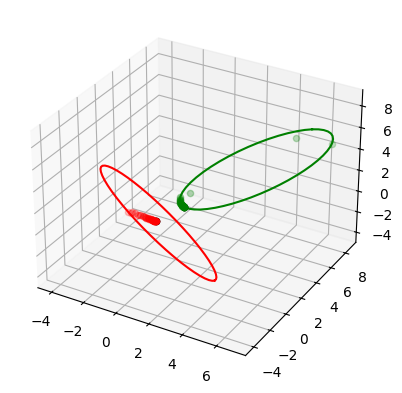

In [63]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
#%matplotlib qt
%matplotlib inline


def add_disk(normal, point, radius, color):
    theta = np.linspace(0, 2*np.pi, 50)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.zeros_like(theta)

    if np.allclose(normal, [0, 0, 1]):
        x_rot, y_rot, z_rot = x, y, z
    else:
        z_axis = np.array([0, 0, 1])
        rot_axis = np.cross(z_axis, normal)
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        rot_angle = np.arccos(np.dot(z_axis, normal))
        
        points = np.vstack([x, y, z])
        rot_matrix = Rotation.from_rotvec(rot_angle * rot_axis).as_matrix()
        rotated_points = rot_matrix @ points
        x_rot, y_rot, z_rot = rotated_points

    x_disk = x_rot + point[0]
    y_disk = y_rot + point[1]
    z_disk = z_rot + point[2]
    ax.plot3D(x_disk, y_disk, z_disk, linestyle='-', color=color, label='Circle')

def xnorm(a):
    ad = math.sqrt(a[0]*a[0]+a[1]*a[1]+a[2]*a[2])
    return [a[0]/ad, a[1]/ad, a[2]/ad]

r=torch.tensor([5])
C1=torch.tensor([0,0,0])
C2=torch.tensor([4,4,4])

max_angle = math.pi**2
max_radius = 5

e1=[1/(3**(1/2)), 1/(3**(1/2)), 1/(3**(1/2))]
e2=[-2/(3**(1/2)), 1/(3**(1/2)), 1/(3**(1/2))]

#params = (torch.rand(1)*r).requires_grad_(), (torch.rand(1)*math.pi*2).requires_grad_(), (torch.rand(1)*r).requires_grad_(), (torch.rand(1)*math.pi*2).requires_grad_()
params = (torch.tensor([1.])*max_radius).requires_grad_(), (torch.rand(1)*max_angle).requires_grad_(), (torch.tensor([1.])*max_radius).requires_grad_(), (torch.rand(1)*max_angle).requires_grad_()

radius1, theta1, radius2, theta2 = params

def loss(radius1, theta1, radius2, theta2):
    radius1_clamped = torch.clamp(radius1, 0, max_radius)
    radius2_clamped = torch.clamp(radius2, 0, max_radius)
    
    a1 = F.normalize(torch.tensor([0,0,1], dtype=torch.float32), dim=0)
    n1 = F.normalize(torch.tensor(e1, dtype=torch.float32), dim=0)

    v1=F.normalize(torch.cross(n1, a1), dim=0)
    u1=F.normalize(torch.cross(n1, v1), dim=0)

    point1=C1+(radius1_clamped*torch.sin(theta1)*v1+radius1_clamped*torch.cos(theta1)*u1)

    a2 = F.normalize(torch.tensor([0,0,1], dtype=torch.float32), dim=0)
    n2 = F.normalize(torch.tensor(e2, dtype=torch.float32), dim=0)

    v2=F.normalize(torch.cross(n2, a2), dim=0)
    u2=F.normalize(torch.cross(n2, v2), dim=0)

    point2=C2+(radius2_clamped*torch.sin(theta2)*v2+radius2_clamped*torch.cos(theta2)*u2)

    loss = (torch.sum((point2-point1)**2))**0.5
    loss.backward()
    return loss, point1, point2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

iterations=200

alpha = 0.2
d_alpha = (1-alpha)/iterations
for i in range(0, iterations):
    lr=0.1
    l, point1, point2 = loss(radius1, theta1, radius2, theta2)
    for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()
    alpha += d_alpha
    if i == iterations-1:
        ax.scatter(*(point1.clone().detach().numpy()), color='k', alpha=1)
        ax.scatter(*(point2.clone().detach().numpy()), color='k', alpha=1)
    elif i % 10 == 0:
        print('Loss Train Set:', l.item())
        ax.scatter(*(point1.clone().detach().numpy()), color='r', alpha=alpha)
        ax.scatter(*(point2.clone().detach().numpy()), color='g', alpha=alpha)

ax.scatter(*(point1.clone().detach().numpy()), color='k', alpha=1)
ax.scatter(*(point2.clone().detach().numpy()), color='k', alpha=1)
add_disk(xnorm(e1), C1.clone().detach().numpy(), r, 'r')
add_disk(xnorm(e2), C2.clone().detach().numpy(), r, 'g')
plt.show()

#### Solution 2: Uses optimizer

Loss Train Set: 13.513673782348633
Loss Train Set: 9.281537055969238
Loss Train Set: 4.549767017364502
Loss Train Set: 3.8337228298187256
Loss Train Set: 2.4218761920928955
Loss Train Set: 2.0186269283294678
Loss Train Set: 1.9637514352798462
Loss Train Set: 1.961374282836914


C:\Users\markr\AppData\Local\Temp\ipykernel_34728\2852109477.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = radius * np.cos(theta)
C:\Users\markr\AppData\Local\Temp\ipykernel_34728\2852109477.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = radius * np.sin(theta)


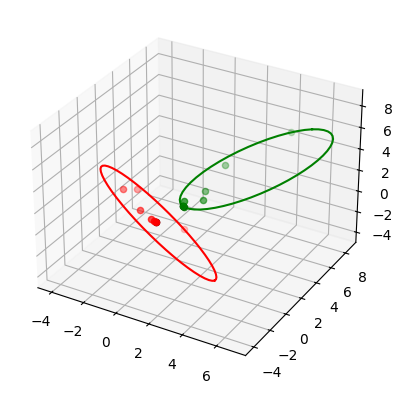

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
#%matplotlib qt
%matplotlib inline


def add_disk(normal, point, radius, color):
    theta = np.linspace(0, 2*np.pi, 50)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.zeros_like(theta)

    if np.allclose(normal, [0, 0, 1]):
        x_rot, y_rot, z_rot = x, y, z
    else:
        z_axis = np.array([0, 0, 1])
        rot_axis = np.cross(z_axis, normal)
        rot_axis = rot_axis / np.linalg.norm(rot_axis)
        rot_angle = np.arccos(np.dot(z_axis, normal))
        
        points = np.vstack([x, y, z])
        rot_matrix = Rotation.from_rotvec(rot_angle * rot_axis).as_matrix()
        rotated_points = rot_matrix @ points
        x_rot, y_rot, z_rot = rotated_points

    x_disk = x_rot + point[0]
    y_disk = y_rot + point[1]
    z_disk = z_rot + point[2]
    ax.plot3D(x_disk, y_disk, z_disk, linestyle='-', color=color, label='Circle')

def xnorm(a):
    ad = math.sqrt(a[0]*a[0]+a[1]*a[1]+a[2]*a[2])
    return [a[0]/ad, a[1]/ad, a[2]/ad]

r=torch.tensor([5])
C1=torch.tensor([0,0,0])
C2=torch.tensor([4,4,4])

max_angle = math.pi**2
max_radius = 5

e1=[1/(3**(1/2)), 1/(3**(1/2)), 1/(3**(1/2))]
e2=[-2/(3**(1/2)), 1/(3**(1/2)), 1/(3**(1/2))]

#params = (torch.rand(1)*r).requires_grad_(), (torch.rand(1)*math.pi*2).requires_grad_(), (torch.rand(1)*r).requires_grad_(), (torch.rand(1)*math.pi*2).requires_grad_()
params = (torch.tensor([1.])*max_radius).requires_grad_(), (torch.rand(1)*max_angle).requires_grad_(), (torch.tensor([1.])*max_radius).requires_grad_(), (torch.rand(1)*max_angle).requires_grad_()

radius1, theta1, radius2, theta2 = params

def loss(radius1, theta1, radius2, theta2):
    radius1_clamped = torch.clamp(radius1, 0, max_radius)
    radius2_clamped = torch.clamp(radius2, 0, max_radius)
    
    a1 = F.normalize(torch.tensor([0,0,1], dtype=torch.float32), dim=0)
    n1 = F.normalize(torch.tensor(e1, dtype=torch.float32), dim=0)

    v1=F.normalize(torch.cross(n1, a1), dim=0)
    u1=F.normalize(torch.cross(n1, v1), dim=0)

    point1=C1+(radius1_clamped*torch.sin(theta1)*v1+radius1_clamped*torch.cos(theta1)*u1)

    a2 = F.normalize(torch.tensor([0,0,1], dtype=torch.float32), dim=0)
    n2 = F.normalize(torch.tensor(e2, dtype=torch.float32), dim=0)

    v2=F.normalize(torch.cross(n2, a2), dim=0)
    u2=F.normalize(torch.cross(n2, v2), dim=0)

    point2=C2+(radius2_clamped*torch.sin(theta2)*v2+radius2_clamped*torch.cos(theta2)*u2)

    loss = (torch.sum((point2-point1)**2))**0.5
    loss.backward()
    return loss, point1, point2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

optimizer = torch.optim.Adam([radius1, theta1, radius2, theta2], lr=0.1, weight_decay=0)

iterations = 65

alpha = 0.2
d_alpha = (1-alpha)/iterations
for i in range(0, iterations):
    optimizer.zero_grad()
    l, point1, point2 = loss(radius1, theta1, radius2, theta2)
    optimizer.step()
    alpha += d_alpha
    if i == iterations-1:
        ax.scatter(*(point1.clone().detach().numpy()), color='k', alpha=1)
        ax.scatter(*(point2.clone().detach().numpy()), color='k', alpha=1)
    elif i % 10 == 0:
        print('Loss Train Set:', l.item())
        ax.scatter(*(point1.clone().detach().numpy()), color='r', alpha=alpha)
        ax.scatter(*(point2.clone().detach().numpy()), color='g', alpha=alpha)

print('Loss Train Set:', l.item())

add_disk(xnorm(e1), C1.clone().detach().numpy(), r, 'r')
add_disk(xnorm(e2), C2.clone().detach().numpy(), r, 'g')
plt.show()